In [3]:
import numpy as np
import scipy.linalg
from numba import njit, prange
import knv as kNV
import qutip as qu

import matplotlib.pyplot as plt

In [5]:
import sys
import os
sys.path.append(os.path.abspath(r'C:/Users/koko/GIT/parament/src/python/pyparament/'))
os.environ['PARAMENT_LIB_DIR'] = os.path.abspath(r'C:/Users/koko/GIT/parament/build')
import parament

In [8]:
dtype_base = np.complex128

ox = np.array([[0,1],[1,0]],dtype=dtype_base)
oy = np.array([[0,-1j],[1j,0]],dtype=dtype_base)
oz = np.array([[1,0],[0,-1]],dtype=dtype_base)
oe = np.array([[1,0],[0,1]],dtype=dtype_base)

w0  = 1.0
w1  = 0.1
wrf = 1.0
TSTOP = 6

H0 = w0/2 * oz
H1 = w1/2 * ox
H2 = w1/2 * oy
Hc = np.zeros((2,2,2),dtype=dtype_base)
Hc[:,:,0] = H1
Hc[:,:,1] = H2

In [12]:
GPURunner = parament.Parament(precision='fp32')
GPURunner.setHamiltonian(H0,H1,use_magnus=True)
propagator = GPURunner.equiprop(c,dt)
GPURunner.destroy()

NameError: name 'dt' is not defined

In [13]:
def Uexact(t):
    dw = w0 - wrf
    #print(dw)
    gen = np.sqrt(w1**2+dw**2)
    explabM = np.exp(-0.5j*t*wrf)
    explabP = np.exp(0.5j*t*wrf)
    x = 0.5*gen*t
    fact1 = dw/gen
    fact2 = w1/gen
    M1 = explabM*(np.cos(x) + 1j*fact1 * np.sin(x))
    M2 = explabM*(-1j*fact2*np.sin(x))
    M3 = explabP*(-1j*fact2*np.sin(x))
    M4 = explabP*(np.cos(x) - 1j*fact1 * np.sin(x))  
    return np.array([[M1,M2],[M3,M4]])
    

In [14]:
def compare(pts,prec,magnus,quad):
    print(pts)
    GPURunner = parament.Parament(precision=prec)
    GPURunner.setHamiltonian(H0,Hc,use_magnus=magnus,quadrature_mode=quad)
    t = np.linspace(0,TSTOP,pts)
    dt = t[1]-t[0]
    carr1 = (np.cos(wrf*t))
    carr2 = (np.sin(wrf*t))

    carr = np.array([carr1,carr2])
    carr = np.transpose(carr)
    outGPU = GPURunner.equiprop(carr,dt)
    #u,s,v = np.linalg.svd(outGPU)
    #outGPU = u @ v
    print(outGPU)
    print("------------")
    Qout = qu.Qobj(outGPU).tidyup()
    GPURunner.destroy()
    propagator_exact = Uexact(TSTOP)
    Ndiff = outGPU - propagator_exact
    Qexact = qu.Qobj(propagator_exact).tidyup()
    Qdiff = Qout - Qexact
    norm_diff = np.linalg.norm(Qdiff.data.todense())
    print(norm_diff)
    return norm_diff

In [6]:
steps = np.logspace(1,4.5,dtype=int)
for i in range(len(steps)):
    if steps[i] % 2 == 0:
        steps[i] = steps[i]+1

In [7]:
y1 = qu.serial_map(compare,steps,task_args=('fp32',True,'simpson'))
y2 = qu.serial_map(compare,steps,task_args=('fp32',False,'midpoint'))
y3 = qu.serial_map(compare,steps,task_args=('fp32',False,'simpson'))



11
[[-0.9465542 -0.1340018j  -0.04140342+0.29045546j]
 [ 0.04140343+0.29045546j -0.9465542 +0.13400176j]]
------------
0.0034062963179265007
11
[[-0.9465542 -0.1340018j  -0.04140342+0.29045546j]
 [ 0.04140343+0.29045546j -0.9465542 +0.13400176j]]
------------
0.0034062963179265007
13
[[-0.94615984-0.13440996j -0.04155643+0.29152876j]
 [ 0.04155642+0.29152876j -0.94615984+0.13440986j]]
------------
0.001675766020084212
17
[[-0.9459001 -0.13468364j -0.04165635+0.2922299j ]
 [ 0.0416564 +0.29222992j -0.9458998 +0.13468379j]]
------------
0.0005407790337103827
19
[[-0.94585407-0.13473326j -0.04167406+0.29235405j]
 [ 0.04167405+0.29235405j -0.945854  +0.1347332j ]]
------------
0.00033937487775791505
23
[[-0.9458106 -0.13477924j -0.04169041+0.29246852j]
 [ 0.04169036+0.29246855j -0.9458107 +0.13477902j]]
------------
0.0001530266455264257
27
[[-0.9457942 -0.13479744j -0.04169692+0.2925145j ]
 [ 0.04169693+0.29251447j -0.9457945 +0.13479751j]]
------------
7.879494245287111e-05
31
[[-0.94578

[[-0.9461908 -0.13480774j -0.04151678+0.29125085j]
 [ 0.04151681+0.29125082j -0.94619066+0.1348079j ]]
------------
0.0019638187019675956
43
[[-0.9460785 -0.13480975j -0.04156628+0.29159802j]
 [ 0.04156632+0.291598j   -0.9460793 +0.13481006j]]
------------
0.0014432853608570817
51
[[-0.9459896 -0.13481185j -0.04160674+0.29188186j]
 [ 0.04160676+0.29188186j -0.9459903 +0.13481203j]]
------------
0.0010187361461773353
61
[[-0.94592685-0.13481393j -0.04163655+0.29209048j]
 [ 0.04163644+0.29209054j -0.9459269 +0.13481359j]]
------------
0.0007076293035652133
71
[[-0.9458856 -0.1348143j  -0.04165431+0.29221556j]
 [ 0.04165431+0.29221553j -0.9458865 +0.13481446j]]
------------
0.0005199187400619867
85
[[-0.94585484-0.13481621j -0.04166959+0.2923225j ]
 [ 0.04166955+0.29232252j -0.94585574+0.13481624j]]
------------
0.0003611218836015764
101
[[-0.9458252 -0.13481492j -0.04167939+0.29239157j]
 [ 0.04167944+0.29239157j -0.94582796+0.13481547j]]
------------
0.00025487415462597526
117
[[-0.94581

0.0003800202703101231
139
[[-0.9458312 -0.13480616j -0.04167824+0.2923833j ]
 [ 0.04167819+0.29238328j -0.94583184+0.13480614j]]
------------
0.00026861631425963145
163
[[-0.94581735-0.13480943j -0.04168525+0.2924326j ]
 [ 0.04168524+0.29243258j -0.9458153 +0.13480912j]]
------------
0.00019487692284372597
193
[[-0.94579965-0.13481064j -0.04169044+0.29246888j]
 [ 0.0416904 +0.29246885j -0.94580156+0.13481082j]]
------------
0.00013892774751926654
227
[[-0.9458006 -0.13481382j -0.04169448+0.29249707j]
 [ 0.04169444+0.292497j   -0.94580036+0.13481364j]]
------------
0.00010023288640222767
269
[[-0.945793  -0.13481463j -0.04169713+0.29251602j]
 [ 0.04169716+0.29251608j -0.94579375+0.13481481j]]
------------
7.123627490964616e-05
317
[[-0.94579214-0.13481587j -0.04169914+0.2925299j ]
 [ 0.04169913+0.29252994j -0.9457899 +0.13481548j]]
------------
5.160672778628557e-05
373
[[-0.9457841 -0.13481535j -0.04170034+0.29253882j]
 [ 0.04170043+0.2925388j  -0.9457875 +0.13481605j]]
------------
3.

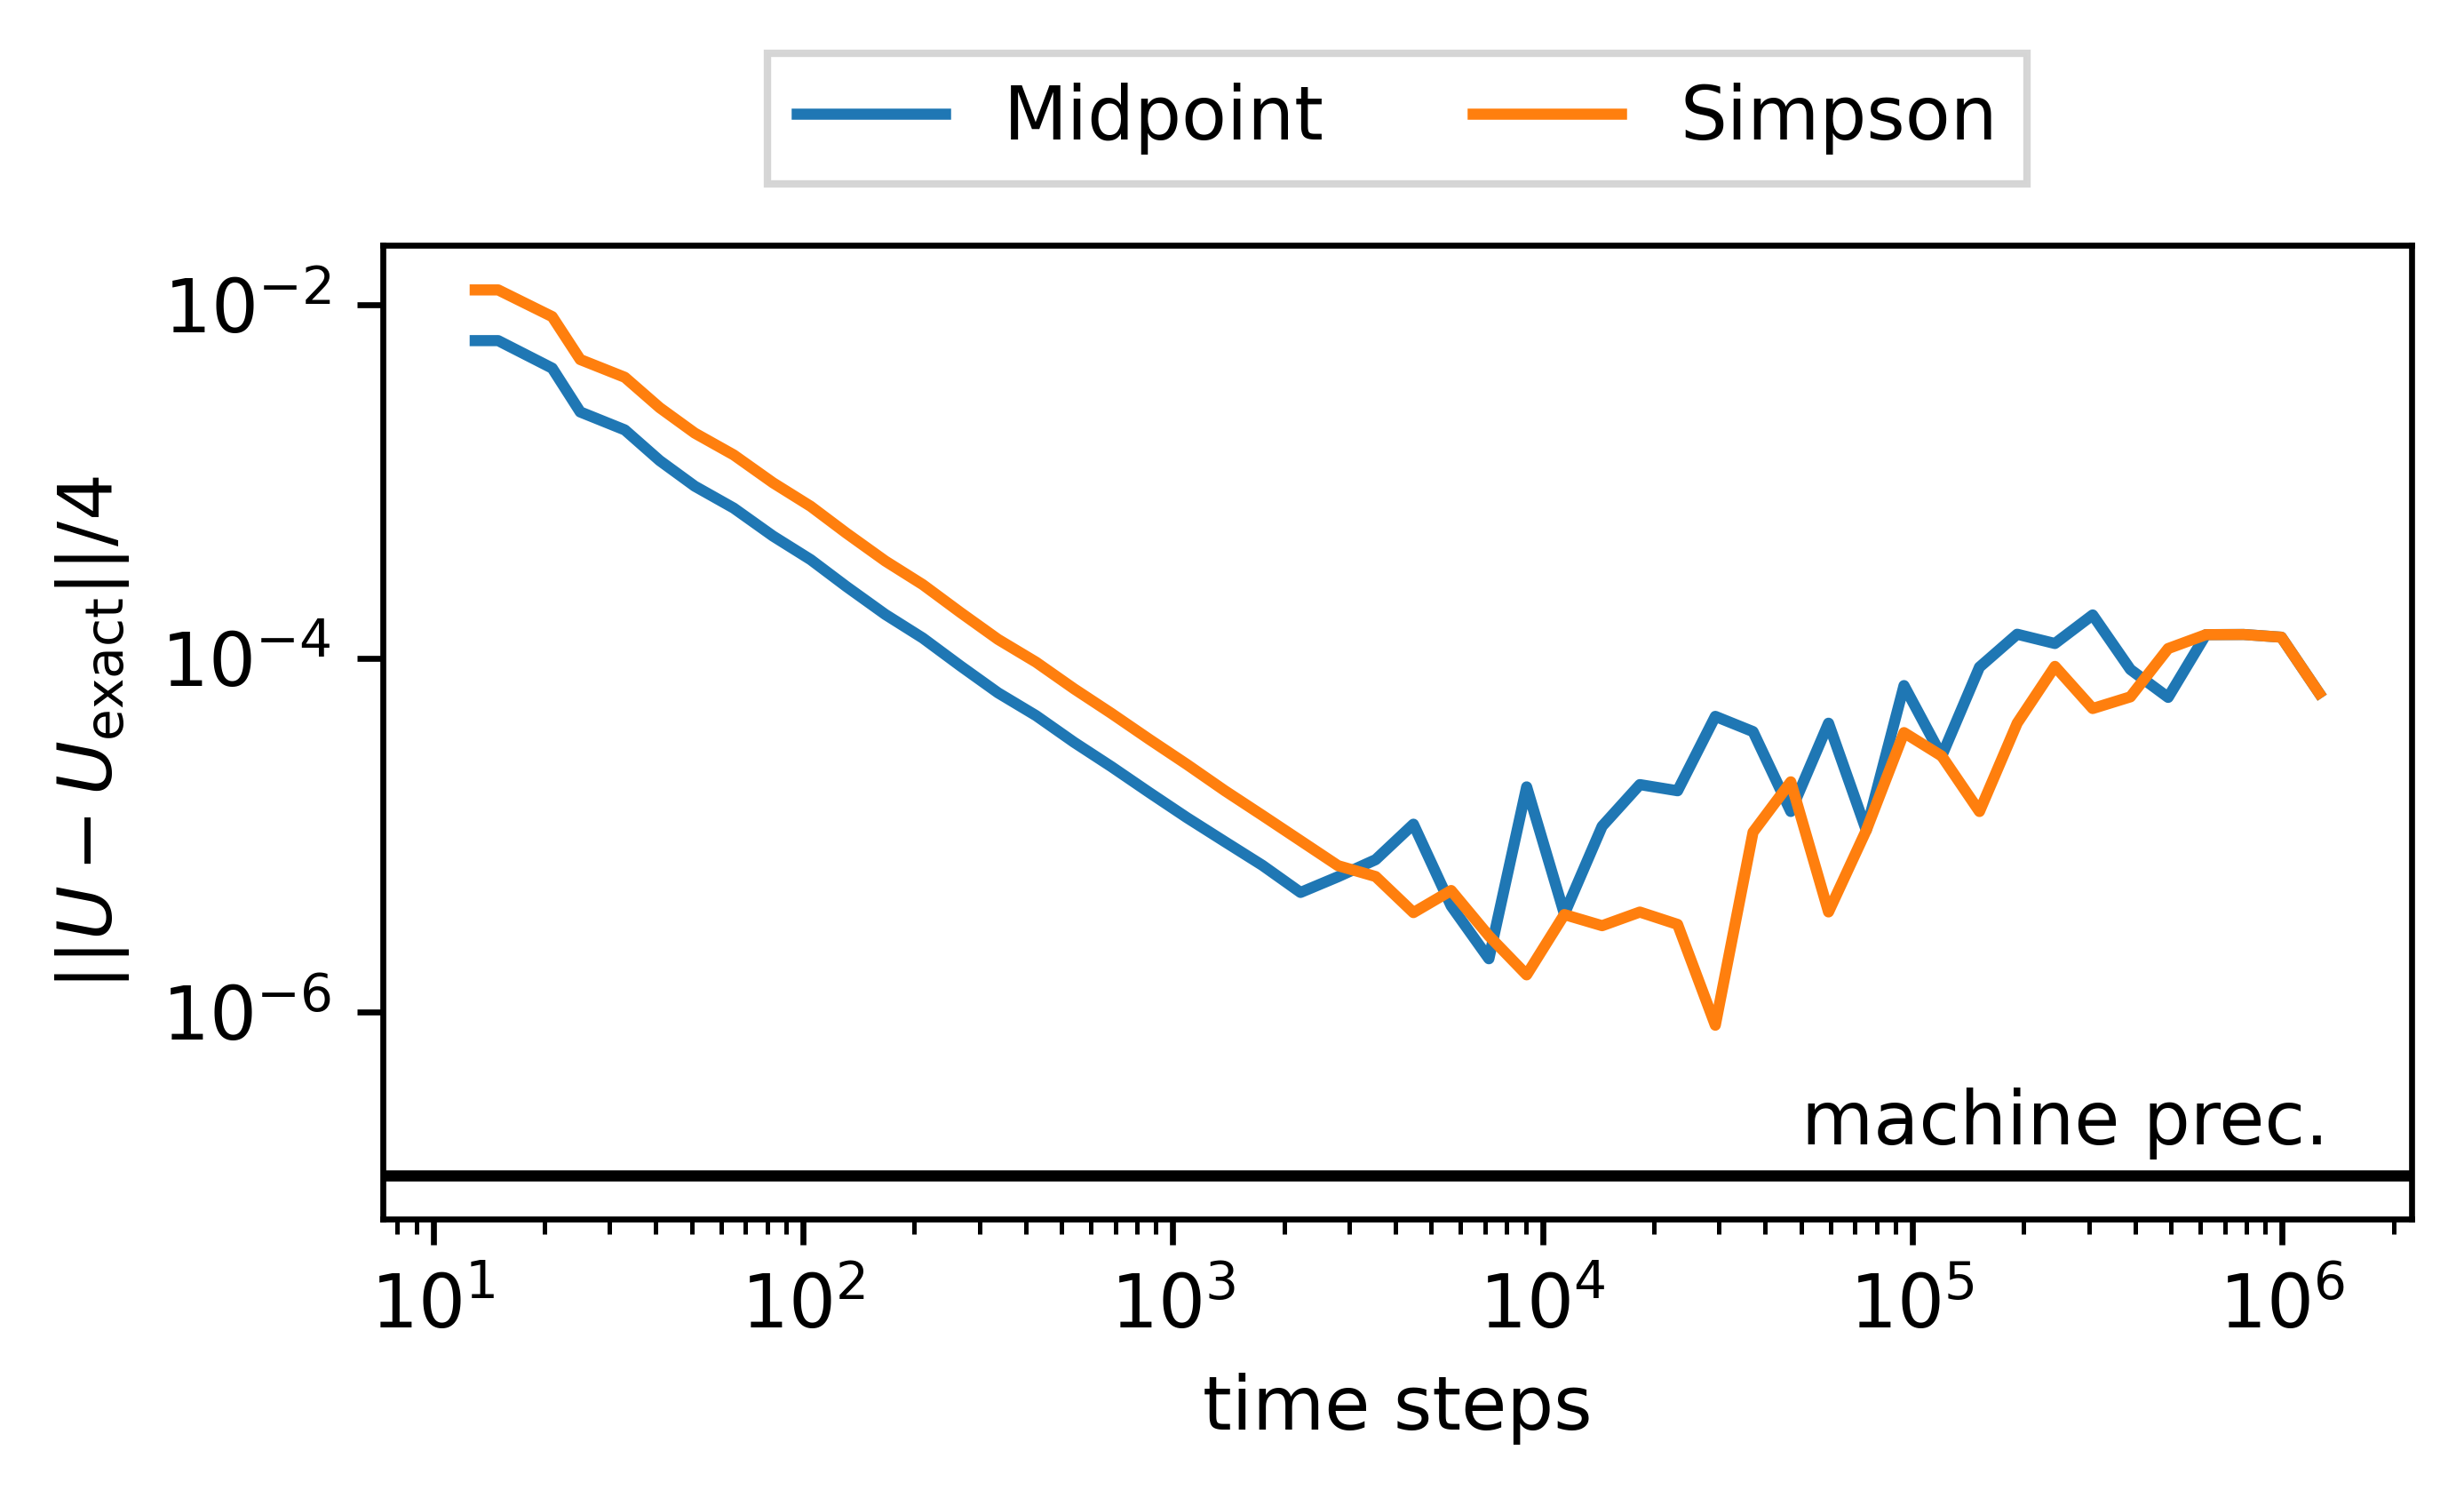

In [54]:
golden_ratio = 1.61803398875
inch = 0.0393701
size = 120
plt.figure(figsize=(size*inch,size*inch/golden_ratio),dpi=600)
plt.loglog(steps,np.array(y2)/4,label='Midpoint')
plt.loglog(steps,np.array(y3)/4,label='Simpson')
#plt.loglog(steps,np.array(y1)/4,label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-23,c='k')
plt.text(5e4,1.5*2**-23,'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig('fp32_convergence.svg')

In [33]:
steps = np.logspace(1.1,6.1,dtype=int)
for i in range(len(steps)):
    if steps[i] % 2 == 0:
        steps[i] = steps[i]+1

In [35]:
steps = np.array([     13,      15,      21,      25,      33,      41,      51,
            65,      83,     105,     131,     167,     211,     267,
           337,     427,     541,     683,     865,    1093,    1383,
          1749,    2217,    2799,    3539,    4477,    5663,    7163,
          9061,   11459,   14495,   18335,   23191,   29333,   37101,
         46927,   59357,   75077,   94963,  120113,  151927,  192165,
        243061,  307437,  388863,  491855,  622125,  786897,  995311,
       1258925])

In [36]:
z1 = qu.serial_map(compare,steps,task_args=('fp64',True,'simpson'))
z2 = qu.serial_map(compare,steps,task_args=('fp64',False,'midpoint'))
z3 = qu.serial_map(compare,steps,task_args=('fp64',False,'simpson'))



13
[[-0.94615966-0.13440972j -0.04155641+0.29152871j]
 [ 0.04155641+0.29152871j -0.94615966+0.13440972j]]
------------
0.001675849848293023
15
[[-0.94598577-0.13459254j -0.04162341+0.29199873j]
 [ 0.04162341+0.29199873j -0.94598577+0.13459254j]]
------------
0.0009154978726443322
21
[[-0.94582724-0.13476157j -0.04168422+0.29242534j]
 [ 0.04168422+0.29242534j -0.94582724+0.13476157j]]
------------
0.00022356060309411757
25
[[-0.94580082-0.13479009j -0.04169432+0.29249621j]
 [ 0.04169432+0.29249621j -0.94580082+0.13479009j]]
------------
0.00010834916344151038
33
[[-0.94578386-0.13480847j -0.0417008 +0.29254163j]
 [ 0.0417008 +0.29254163j -0.94578386+0.13480847j]]
------------
3.445178042059811e-05
41
[[-0.9457792 -0.13481355j -0.04170258+0.2925541j ]
 [ 0.04170258+0.2925541j  -0.9457792 +0.13481355j]]
------------
1.4143554768586292e-05
51
[[-0.94577729-0.13481564j -0.04170331+0.29255923j]
 [ 0.04170331+0.29255923j -0.94577729+0.13481564j]]
------------
5.801754461302332e-06
65
[[-0.945

[[-0.94580785-0.13481634j -0.04168946+0.29246206j]
 [ 0.04168946+0.29246206j -0.94580785+0.13481634j]]
------------
0.0001507927118026561
167
[[-0.94579552-0.13481663j -0.04169501+0.29250101j]
 [ 0.04169501+0.29250101j -0.94579552+0.13481663j]]
------------
9.24844875948639e-05
211
[[-0.94578818-0.13481681j -0.04169831+0.29252419j]
 [ 0.04169831+0.29252419j -0.94578818+0.13481681j]]
------------
5.7790599469930605e-05
267
[[-0.94578357-0.13481691j -0.04170038+0.29253873j]
 [ 0.04170038+0.29253873j -0.94578357+0.13481691j]]
------------
3.6019629491211946e-05
337
[[-0.94578073-0.13481698j -0.04170166+0.29254771j]
 [ 0.04170166+0.29254771j -0.94578073+0.13481698j]]
------------
2.2575018398384077e-05
427
[[-0.94577893-0.13481702j -0.04170248+0.29255341j]
 [ 0.04170248+0.29255341j -0.94577893+0.13481702j]]
------------
1.4043976847205026e-05
541
[[-0.9457778 -0.13481705j -0.04170298+0.29255695j]
 [ 0.04170298+0.29255695j -0.9457778 +0.13481705j]]
------------
8.740241279000124e-06
683
[[-

[[-0.94577653-0.13481699j -0.04170356+0.292561j  ]
 [ 0.04170356+0.292561j   -0.94577653+0.13481699j]]
------------
2.6785337204016734e-06
1749
[[-0.94577632-0.13481703j -0.04170366+0.29256167j]
 [ 0.04170366+0.29256167j -0.94577632+0.13481703j]]
------------
1.6742905006294182e-06
2217
[[-0.94577618-0.13481705j -0.04170372+0.29256209j]
 [ 0.04170372+0.29256209j -0.94577618+0.13481705j]]
------------
1.041776246631542e-06
2799
[[-0.9457761 -0.13481707j -0.04170375+0.29256235j]
 [ 0.04170375+0.29256235j -0.9457761 +0.13481707j]]
------------
6.534595701802876e-07
3539
[[-0.94577604-0.13481708j -0.04170378+0.29256252j]
 [ 0.04170378+0.29256252j -0.94577604+0.13481708j]]
------------
4.086943176323709e-07
4477
[[-0.94577601-0.13481708j -0.04170379+0.29256262j]
 [ 0.04170379+0.29256262j -0.94577601+0.13481708j]]
------------
2.5534900617178936e-07
5663
[[-0.94577599-0.13481709j -0.0417038 +0.29256268j]
 [ 0.0417038 +0.29256268j -0.94577599+0.13481709j]]
------------
1.5957859689527348e-07


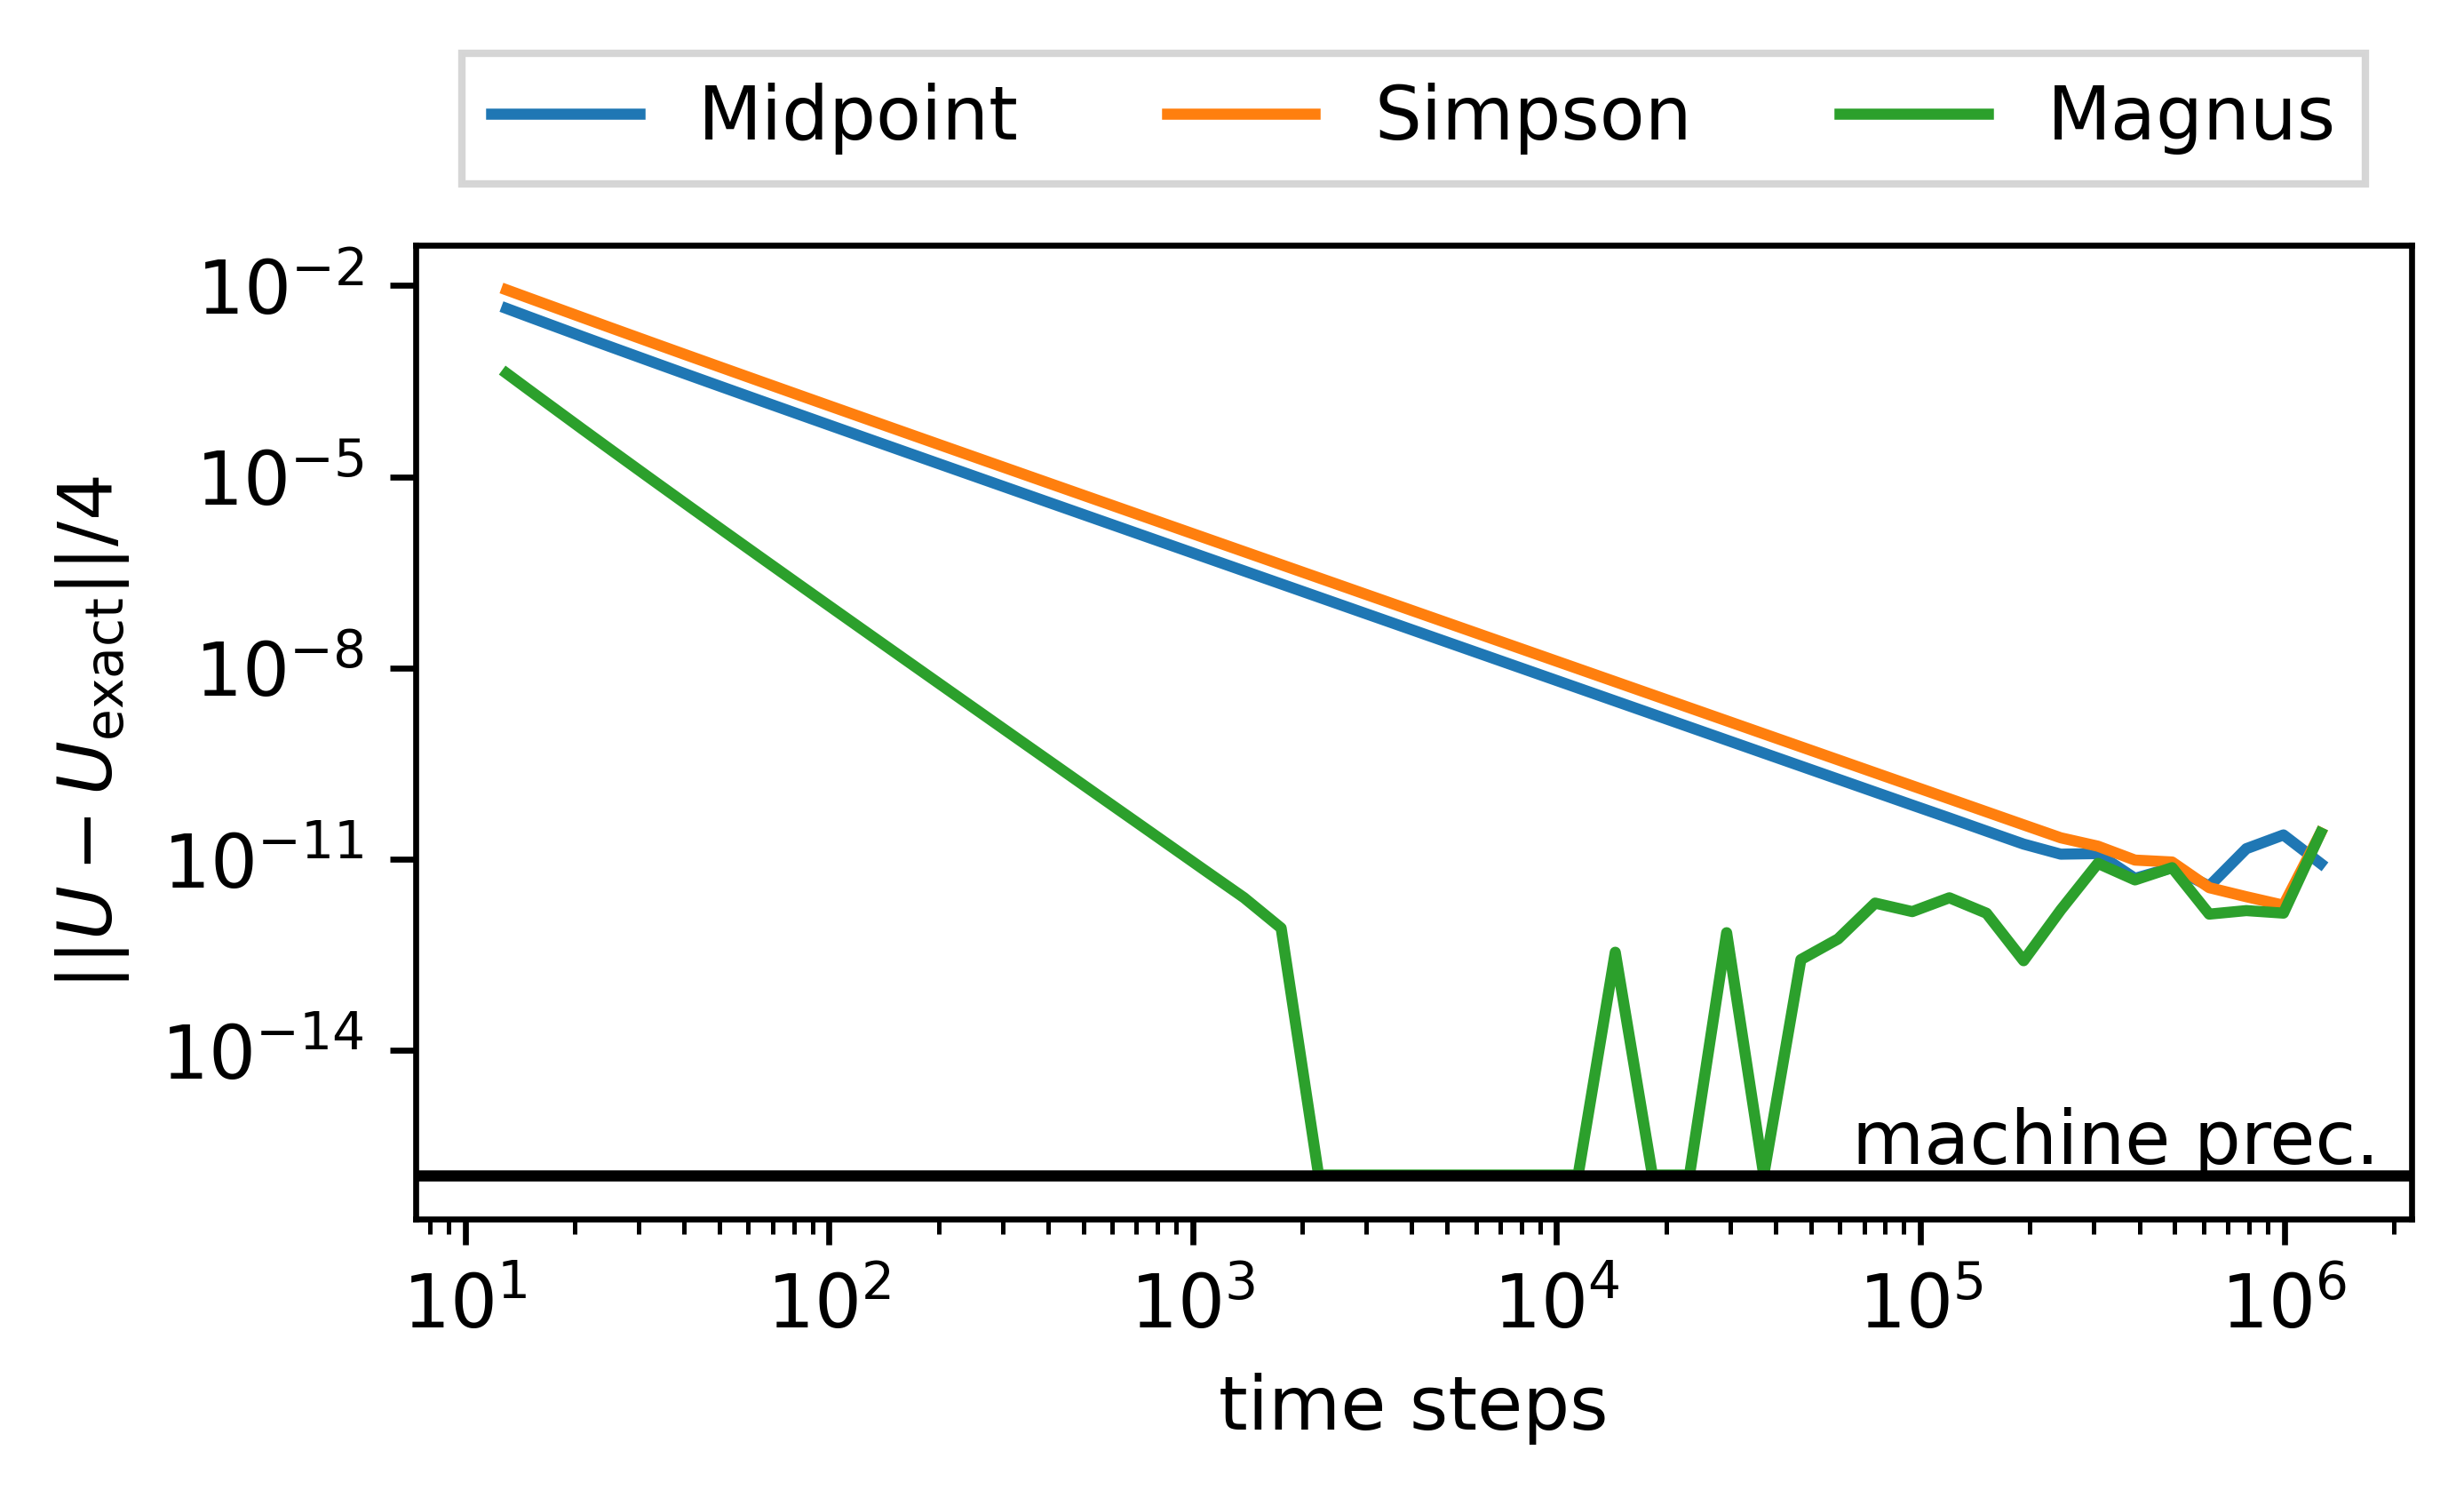

In [48]:
golden_ratio = 1.61803398875
inch = 0.0393701
size = 120
plt.figure(figsize=(size*inch,size*inch/golden_ratio),dpi=600)
plt.loglog(steps,np.clip(np.array(z2)/4,2**-53,100),label='Midpoint')
plt.loglog(steps,np.clip(np.array(z3)/4,2**-53,100),label='Simpson')
plt.loglog(steps,np.clip(np.array(z1)/4,2**-53,100),label='Magnus')
plt.ylabel('$||U-U_\mathrm{exact}||/4$')
plt.xlabel('time steps')
plt.axhline(2**-53,c='k')
plt.text(6.5e4,1.5*2**-53,'machine prec.')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.025),
          ncol=3, fancybox=False, shadow=False)
plt.tight_layout()
plt.savefig('fp64_convergence.svg')

In [18]:
np.log10(5589165)

6.747346930788167

In [19]:
for i in range(len(steps)):
    print(steps[i],z1[i])

13 0.001675849848293023
15 0.0009154978726443322
21 0.00022356060309411757
25 0.00010834916344151038
33 3.445178042059811e-05
41 1.4143554768586292e-05
51 5.801754461302332e-06
65 2.1634918883182078e-06
83 8.033468391129024e-07
105 3.1057459819615474e-07
131 1.2723365327891712e-07
167 4.7872704426997236e-08
211 1.868991973477988e-08
267 7.262111256510755e-09
337 2.850276217166983e-09
427 1.1043468615393156e-09
541 4.271369540336611e-10
683 1.6805264263189505e-10
865 6.51898691944489e-11
1093 2.5464155502620447e-11
1383 9.968780130614789e-12
1749 3.3253773237959596e-12
2217 0.0
2799 0.0
3539 0.0
4477 0.0
5663 0.0
7163 0.0
9061 0.0
11459 0.0
14495 1.390221271435621e-12
18335 0.0
23191 0.0
29333 2.8162469897714635e-12
37101 0.0
46927 1.0654810367327627e-12
59357 2.2437341031877854e-12
75077 8.206374653336343e-12
94963 6.03287709711511e-12
120113 9.94428409773428e-12
151927 5.692234373281653e-12
192165 1.0232925617970068e-12
243061 6.393987470034224e-12
307437 3.449168034490689e-11
388863 